# TTC Delay Forecasting

In [1]:
from config import data_path

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dateutil.parser import parse

import re #for parsing
import time

##import libraries
# from data_load import *

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, GRU, Dense, Concatenate, Input, Flatten
import numpy as np


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split

2024-12-04 14:40:14.293408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 14:40:14.384772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 14:40:14.414780: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 14:40:14.550781: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 14:40:15.815981: W tensorflow/comp

In [2]:
# Defining parsing function
def standardize_time(time_str):
    # Add seconds if missing
    if len(time_str.split(':')) == 2:  # Format is h:m
        time_str += ':00'
    return time_str

def standardize_time_format(time_str):
    try:
        # Parse the time string
        parsed_time = parse(str(time_str)).time()  # Extract only the time
        # Format to HH:MM:SS
        return parsed_time.strftime('%H:%M:%S')
    except Exception as e:
        print(f"Could not parse '{time_str}': {e}")
        return None
    
def standardize_date_format(date_str):
    try:
        # Parse the date string
        parsed_date = parse(str(date_str)) 
        # Format to YYYY-MM-DD
        return parsed_date.strftime('%Y-%m-%d')
    except Exception as e:
        print(f"Could not parse '{date_str}': {e}")
        return None
    
def parse_string(s):
    try:
        s = s.lower()                   # convert to lowercase
        s = s.replace("station", "stn") # replace "station" with "stn"
        s = s.replace("&", "and")       # replace "&" with "and"
        s = s.replace("centre","center") #other spellings
        s = re.sub(r'\bu\b', 'university', s)
        s = s.replace('stn.','stn')
        s = s.replace("st. clair", "st clair")
        s = s.replace("sta", "station")

        return s
    except Exception as e:
        print(f"Could not parse '{s}': {e}")
        return None



#Defining data loading
def loadRawData(vehicle_type="bus",start_year = 2014, end_year = 2015, data_path = data_path):
    """
    vehicle_type = bus, subway, streetcar
    start_year = start of year range
    end_year = end of year range
    targets = targets of dataset
    features = features of dataset
    loads data, based off given parameters
    """
    # print('subfolder path', data_path)
    subfolder_path = os.path.join(data_path, vehicle_type)

    print('subfolder path', subfolder_path)
    if not os.path.isdir(subfolder_path):
            print("error")
            raise ValueError(f"Subfolder '{vehicle_type}' does not exist in {data_path}.") #making sure path is correct

    all_data = pd.DataFrame()

    for filename in os.listdir(subfolder_path):
        
        print("On filename:",filename)

        if (
            filename.endswith(".xlsx") and
            filename.startswith(f"ttc-{vehicle_type}-delay-data") and
            start_year <= int(filename.split("-")[-1].split(".")[0]) <= end_year
        ):
                file_path = os.path.join(subfolder_path, filename)
                sheet_names = pd.ExcelFile(file_path).sheet_names
                for month in sheet_names:
                    data = pd.read_excel(file_path,sheet_name=month)
                    # print(data.columns)
                    # accounting for inconsistent data formatting
                    if 'Report Date' in data.columns:
                        pass  # Column is already named "Date"
                        
                    elif 'Date' in data.columns:
                        # print("Renamed date to report date")
                        data.rename(columns={'Date': 'Report Date'}, inplace=True)

                    if 'Delay' in data.columns:
                        # print("Renamed Delay to Min Delay")
                        data.rename(columns={'Delay': 'Min Delay'}, inplace=True)
                    elif 'Min Delay' in data.columns:
                        pass  # Column is already named Min Delay
                    
                    all_data = pd.concat([all_data, data], ignore_index=True)    
    return all_data

In [3]:
import os
import pandas as pd


#testing to see

def loadRawData_NODIV(vehicle_type="bus", start_year=2014, end_year=2015, data_path=data_path):
    """
    vehicle_type = bus, subway, streetcar
    start_year = start of year range
    end_year = end of year range
    data_path = path to the data folder
    loads data, based off given parameters
    """
    # Define the subfolder path based on the vehicle type
    subfolder_path = os.path.join(data_path, vehicle_type)

    print('subfolder path', subfolder_path)
    if not os.path.isdir(subfolder_path):
        print("error")
        raise ValueError(f"Subfolder '{vehicle_type}' does not exist in {data_path}.")  # Check if path is correct

    all_data = pd.DataFrame()

    for filename in os.listdir(subfolder_path):
        print("On filename:", filename)

        # Only process relevant files based on the filename structure and year range
        if (
            filename.endswith(".xlsx") and
            filename.startswith(f"ttc-{vehicle_type}-delay-data") and
            start_year <= int(filename.split("-")[-1].split(".")[0]) <= end_year
        ):
            file_path = os.path.join(subfolder_path, filename)
            sheet_names = pd.ExcelFile(file_path).sheet_names
            for month in sheet_names:
                data = pd.read_excel(file_path, sheet_name=month)
                
                # Accounting for inconsistent data formatting and renaming columns as necessary
                if 'Report Date' in data.columns:
                    pass  # Column is already named "Report Date"
                elif 'Date' in data.columns:
                    # Rename 'Date' to 'Report Date'
                    data.rename(columns={'Date': 'Report Date'}, inplace=True)

                if 'Delay' in data.columns:
                    # Rename 'Delay' to 'Min Delay'
                    data.rename(columns={'Delay': 'Min Delay'}, inplace=True)
                elif 'Min Delay' in data.columns:
                    pass  # Column is already named "Min Delay"
                
                # Filter out rows where the "incident" column is "Diversion"
                if 'Incident' in data.columns:
                    data = data[data['Incident'] != 'Diversion']

                # Concatenate the processed data
                all_data = pd.concat([all_data, data], ignore_index=True)

    return all_data


In [4]:
#Defining sliding window function

def create_sliding_windows(df, n_steps, n_outputs, target_column):
    """
    Converts a DataFrame into overlapping sliding windows.

    Parameters:
    - df: Input DataFrame with features and target variable.
    - n_steps: Number of time steps in the input sequence.
    - n_outputs: Number of time steps in the output sequence.
    - target_column: Name or index of the target column.

    Returns:
    - X: Numpy array of shape (num_samples, n_steps, num_features)
    - y: Numpy array of shape (num_samples, n_outputs)
    """
    X, y = [], []
    if isinstance(target_column, str):
        target_index = df.columns.get_loc(target_column)  # Get column index
    else:
        target_index = target_column

    data = df.to_numpy()  # Convert to NumPy for efficiency
    for i in range(len(data) - n_steps - n_outputs + 1):
        # Include all columns except the target in X
        X.append(data[i:i + n_steps, :])
        # Use only the target column for y
        y.append(data[i + n_steps:i + n_steps + n_outputs, target_index])
    X = np.array(X)
    y = np.array(y)

    # Exclude the target column from X (optional if the target is among features)
    # X = np.delete(X, target_index, axis=-1)
    return X, y

In [5]:
''' #code to investigate into the direction column / cardinality
description = df['Direction'].describe()
print("Summary Statistics:\n", description)
unique_values_count = df['Direction'].nunique()
print(len(df['Direction']))
print(f"Number of unique values in 'Location': {unique_values_count}")

import matplotlib.pyplot as plt


# Plot the top 10 most common labels
top_labels = df['Direction'].value_counts().head(50)
top_labels_list = top_labels.index.tolist()
print(top_labels_list)
# for label in top_labels_list:
#      print(label)

top_labels.plot(kind='bar', figsize=(10, 5))

# Set title and labels
plt.title('Direction vs Frequency')
plt.xlabel('Direction')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
'''
''' #code to investigate the Location column / cardinality:
description = df['Location'].describe()
print("Summary Statistics:\n", description)
unique_values_count = df['Location'].nunique()
print(len(df['Location']))
print(f"Number of unique values in 'Location': {unique_values_count}")

import matplotlib.pyplot as plt


# Plot the top 10 most common labels
top_labels = df['Location'].value_counts().head(1000)
top_labels_list = top_labels.index.tolist()
print(top_labels_list)
# for label in top_labels_list:
#      print(label)

top_labels.plot(kind='bar', figsize=(100, 20))

# Set title and labels
plt.title('Top 500 Most Frequent Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
'''

' #code to investigate the Location column / cardinality:\ndescription = df[\'Location\'].describe()\nprint("Summary Statistics:\n", description)\nunique_values_count = df[\'Location\'].nunique()\nprint(len(df[\'Location\']))\nprint(f"Number of unique values in \'Location\': {unique_values_count}")\n\nimport matplotlib.pyplot as plt\n\n\n# Plot the top 10 most common labels\ntop_labels = df[\'Location\'].value_counts().head(1000)\ntop_labels_list = top_labels.index.tolist()\nprint(top_labels_list)\n# for label in top_labels_list:\n#      print(label)\n\ntop_labels.plot(kind=\'bar\', figsize=(100, 20))\n\n# Set title and labels\nplt.title(\'Top 500 Most Frequent Labels\')\nplt.xlabel(\'Label\')\nplt.ylabel(\'Frequency\')\nplt.grid(axis=\'y\', linestyle=\'--\', alpha=0.7)\n\n# Show the plot\nplt.show()\n'

In [6]:
#getting data
vehicle_type = 'bus'
start_year = 2014 #min
end_year = 2024 #max

#number of outputs: (how many points ahead to forecast)s

targets = ["Min Delay"]
features = ["Report Date", "Time","Direction", "Location", "Route"]

print("Loading data")
df_raw = loadRawData_NODIV(vehicle_type=vehicle_type,start_year=start_year,end_year=end_year)

print("Finished loading data")

Loading data
subfolder path /media/jadenh/SSD2/TTC_DATA/bus
On filename: ttc-bus-delay-data-2014.xlsx
On filename: ttc-bus-delay-data-2015.xlsx
On filename: ttc-bus-delay-data-2016.xlsx
On filename: ttc-bus-delay-data-2017.xlsx
On filename: ttc-bus-delay-data-2018.xlsx
On filename: ttc-bus-delay-data-2019.xlsx
On filename: ttc-bus-delay-data-2020.xlsx
On filename: ttc-bus-delay-data-2021.xlsx
On filename: ttc-bus-delay-data-2022.xlsx
On filename: ttc-bus-delay-data-2023.xlsx
On filename: ttc-bus-delay-data-2024.xlsx
Finished loading data


In [7]:
## Defining parameters:
df = df_raw.copy()

n_outputs = 4 #forecasting 1 hours of delays(4 |delays / hour * 2 hours)
n_steps = 50 # how many points to use # assuming about 4 delays per hour * 24 hours / day ~ 100 points of data
## Processing Data

#first, sort index
df = df.sort_index() 

print("Using features:\n",features,"\nTargets:",targets)

df = df[targets+features] #only using necessary data
df.dropna(axis=0, how='any', inplace=True) #drops empty rows where any are null  
print("target + features + dropped empty:\n",df.head())


# applying parsing functions to the time and date (due to different formats)
df['Time'] = df['Time'].apply(standardize_time_format)
df['Report Date'] = df['Report Date'].apply(standardize_date_format)
# df['Location_encode'] = df['Location'].apply(parse_string) #may not need if we use embedding ?

df['Datetime'] = pd.to_datetime((df['Report Date'] + ' ' + df['Time']),format='%Y-%m-%d %H:%M:%S') #combining into one column
df.drop(columns = ['Time','Report Date'], inplace = True)

# preprocessing the DIRECTION to make consistent 4 + 1 directions 
valid_directions = ['n','s','e','w','b'] #should only have n,e,s,w, b - both ways
df['Direction'] = df['Direction'].str[0].str.lower()
df['Direction'] = df['Direction'].apply(lambda x: x if x in valid_directions else 'unknown')

df['Location'] = df['Location'].apply(parse_string)

df['Route'] = df['Route'].astype(str)
## one hot encoding 
# the only one hot encoded feature will be: 'Direction', as determined by the data exploration

# df['Direction'] = df['Direction'].astype(str) #formatting necessary????

one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = one_hot_encoder.fit_transform(df[['Direction']])

one_hot_encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(['Direction']))

df = pd.concat([df, one_hot_encoded_df], axis=1)
df.drop(df[['Direction']], axis=1, inplace=True) #removing unecessary columns


# defining encoders for embedding
location_encoder = LabelEncoder()
route_encoder = LabelEncoder()

## Using label encodings and embeddings: #
df['Location_encoded'] = location_encoder.fit_transform(df['Location'])
df['Route_encoded'] = route_encoder.fit_transform(df['Route'])

df = df.drop('Location',axis=1)
df = df.drop('Route',axis=1)

location_vocab_size = len(location_encoder.classes_)  # Number of unique locations
route_vocab_size = len(route_encoder.classes_)  # Number of unique routes


df.dropna(axis=0, how='any', inplace=True) #drops empty rows where any are null  
df.set_index('Datetime',inplace=True)
# Extract year, month, day, hour, and minute from the Datetime index
df['year'] = df.index.year.astype(int)
df['month'] = df.index.month.astype(int)
df['day'] = df.index.day.astype(int)
df['hour'] = df.index.hour.astype(int)
df['minute'] = df.index.minute.astype(int)

# statistics = pd.DataFrame({
#     'max': df[['year', 'month', 'day', 'hour', 'minute']].max(),
#     'min': df[['year', 'month', 'day', 'hour', 'minute']].min(),
#     'std': df[['year', 'month', 'day', 'hour', 'minute']].std()
# })

# print(statistics)
    
scaler = RobustScaler() #because we want model to be robust to outliars of which there are a couple
# scaler = StandardScaler() #standard because we expect standard deviation
# scaler = MinMaxScaler() #min max because ...

df[['Min Delay']] = scaler.fit_transform(df[['Min Delay']])
df.dropna(axis=0, how='any', inplace=True)

# df = df.sort_index() - shouldn't need to sort again

print(df.head())

#split dataframe into embedded encoded features, and regular features (for sliding window)

# embed_features = ['Location_encoded', 'Route_encoded']
# df_embed = df[embed_features]
# df = df.drop(embed_features,axis=1)

delay_stats = df['Min Delay'].describe()
print("Statistics of the min delay:",delay_stats)


# split the dataframes into training and testing dataframes to avoid data leakage
#splitting data
test_size = 0.2
split_index = int(len(df) * (1 - test_size))

df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:] 

test_size = 0.2
split_index = int(len(df) * (1 - test_size))


X_train, y_train = create_sliding_windows(df_train,n_steps,n_outputs,target_column=targets[0])
X_test, y_test = create_sliding_windows(df_test,n_steps,n_outputs,target_column=targets[0])

print("Finished loading data")

print("x train shape:", X_train.shape)
print("x test shape:", X_test.shape)
print("y train shape:", y_train.shape)
print("y test shape:", y_test.shape)

Using features:
 ['Report Date', 'Time', 'Direction', 'Location', 'Route'] 
Targets: ['Min Delay']
target + features + dropped empty:
    Min Delay Report Date      Time Direction              Location  Route
0       10.0  2014-01-01  00:23:00         E    York Mills station   95.0
1       33.0  2014-01-01  00:55:00       b/w  Entire run for route  102.0
2       10.0  2014-01-01  01:28:00        WB   lawrence and Warden   54.0
3       18.0  2014-01-01  01:30:00         N       Kipling Station  112.0
4       10.0  2014-01-01  01:37:00         n      VP and Ellesmere   24.0
                     Min Delay  Direction_e  Direction_n  Direction_s  \
Datetime                                                                
2014-01-01 00:23:00      0.000          1.0          0.0          0.0   
2014-01-01 00:55:00      2.875          0.0          0.0          0.0   
2014-01-01 01:28:00      0.000          0.0          0.0          0.0   
2014-01-01 01:30:00      1.000          0.0          1.0

In [ ]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define a function that creates and compiles the LSTM model
def create_lstm_model(hp):
    # Define the input shapes for time features, location, and route
    n_steps = X_train.shape[1]  # Number of time steps in the sliding window
    n_features = X_train.shape[2] - 2  # Number of features for time inputs

    # Input layers
    features_input = layers.Input(shape=(n_steps, n_features), name='features_input')
    location_input = layers.Input(shape=(n_steps, 1), name='Location_input')
    route_input = layers.Input(shape=(n_steps, 1), name='Route_input')

    # LSTM layers
    lstm_out = layers.LSTM(
        hp.Int('num_neurons_1', min_value=16, max_value=128, step=8), 
        activation='relu', 
        return_sequences=True,
        kernel_regularizer=regularizers.l2(hp.Float('l2_penalty', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    )(features_input)

    lstm_out = layers.BatchNormalization()(lstm_out)
    lstm_out = layers.Dropout(hp.Float('dropout_rate_1', min_value=0.1, max_value=0.8, step=0.05))(lstm_out)

    lstm_out = layers.LSTM(
        hp.Int('num_neurons_2', min_value=8, max_value=64, step=4),
        activation='relu', 
        kernel_regularizer=regularizers.l2(hp.Float('l2_penalty', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    )(lstm_out)
    lstm_out = layers.BatchNormalization()(lstm_out)
    lstm_out = layers.Dropout(hp.Float('dropout_rate_2', min_value=0.1, max_value=0.8, step=0.05))(lstm_out)

    # Embedding layers for categorical features (location and route)
    location_embedded = layers.Embedding(input_dim=location_vocab_size, output_dim=hp.Int('location_embedding_dim', min_value=20, max_value=50, step=10))(location_input)
    route_embedded = layers.Embedding(input_dim=route_vocab_size, output_dim=hp.Int('route_embedding_dim', min_value=5, max_value=20, step=5))(route_input)

    location_embedded = layers.Flatten()(location_embedded)
    route_embedded = layers.Flatten()(route_embedded)

    # Concatenate the LSTM output with the embedded categorical features
    x = layers.Concatenate()([lstm_out, location_embedded, route_embedded])

    # Dense layer for final output
    x = layers.Dense(hp.Int('num_neurons_3', min_value=8, max_value=64, step=4), activation='relu')(x)
    x = layers.BatchNormalization()(x)

    output = layers.Dense(n_outputs)(x)

    # Compile the model
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-8, max_value=1e-3, sampling='LOG'))
    model = models.Model(inputs=[features_input, location_input, route_input], outputs=output)
    model.compile(optimizer=optimizer, metrics=['mse', 'mae'], loss='mae')

    return model

# Define the Hyperband Tuner
lstm_tuner = kt.Hyperband(
    create_lstm_model,
    objective='val_loss',
    max_epochs=25,  # Maximum number of epochs per model
    factor=3,  # Reduction factor for resource allocation
    directory='kt_dir',
    project_name='traffic_delay_lstm_hpo_hyperband'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Splitting the data into non-embedded features and embedded features
X_train_regular = np.concatenate((X_train[:, :, :6], X_train[:, :, 8:]), axis=2)
X_train_location = X_train[:, :, 6:7]
X_train_route = X_train[:, :, 7:8]


batch_size = 128

# Perform the search
lstm_tuner.search(
    [X_train_regular, X_train_location, X_train_route], 
    y_train,
    epochs=25,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=False
)

# Retrieve the best hyperparameters
lstm_best_hyperparameters = lstm_tuner.oracle.get_best_trials()[0].hyperparameters
print("Best Hyperparameters:", lstm_best_hyperparameters)


Reloading Tuner from kt_dir/traffic_delay_lstm_hpo_hyperband/tuner0.json
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x74c102e809a0>


In [14]:
# Build and train the best model
lstm_best_hyperparameters = lstm_tuner.oracle.get_best_trials()[0].hyperparameters
print("Best Hyperparameters:", lstm_best_hyperparameters.values)
lstm_model = lstm_tuner.hypermodel.build(lstm_best_hyperparameters)


lstm_history = lstm_model.fit(
    [X_train_regular, X_train_location, X_train_route], 
    y_train,
    epochs=50,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=False
)

Best Hyperparameters: {'num_neurons_1': 56, 'l2_penalty': 0.00016173166713183553, 'dropout_rate': 0.45, 'num_neurons_2': 12, 'location_embedding_dim': 30, 'route_embedding_dim': 20, 'num_neurons_3': 56, 'learning_rate': 0.0001891457713840509, 'tuner/epochs': 9, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch 1/50
2790/2790 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - loss: 0.7660 - mae: 0.7560 - mse: 1.9647 - val_loss: 0.9176 - val_mae: 0.9093 - val_mse: 8.9027
Epoch 2/50
2790/2790 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - loss: 0.6806 - mae: 0.6728 - mse: 1.7571 - val_loss: 0.9206 - val_mae: 0.9139 - val_mse: 8.9571
Epoch 3/50
2790/2790 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - loss: 0.6494 - mae: 0.6432 - mse: 1.6983 - val_loss: 0.9531 - val_mae: 0.9483 - val_mse: 8.8048
Epoch 4/50
2790/2790 ━━━━━━━━━━━━━━━━━━━━ 56s 20ms/step - loss: 0.5632 - mae: 0.5588 - mse: 1.5398 - val_loss: 0.9834 - val_mae: 0.9798 - val_mse: 8.8994
Epoch 5/50
2790/2790 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - 

(446341, 50, 11) (446341, 50, 1) (446341, 50, 1) (446341, 4)
(111546, 50, 11) (111546, 50, 1) (111546, 50, 1) (111546, 4)
13949/13949 ━━━━━━━━━━━━━━━━━━━━ 134s 10ms/step - loss: 0.6915 - mae: 0.6832 - mse: 1.9974
3486/3486 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - loss: 1.0409 - mae: 1.0326 - mse: 12.7011
Training Metrics:
loss: 0.7448
mae: 0.7365
mse: 3.8040

Testing Metrics:
loss: 0.9336
mae: 0.9253
mse: 8.4794


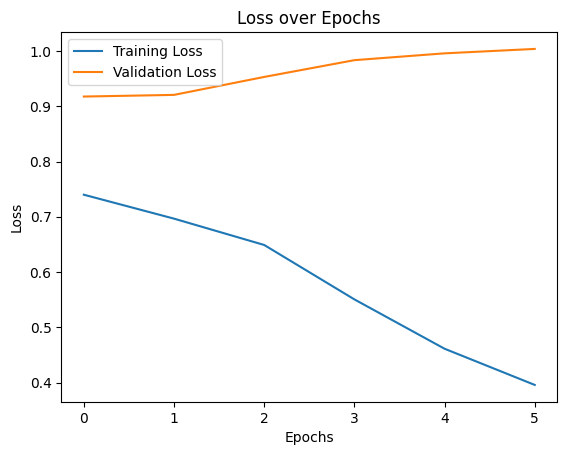

In [15]:
def test_model(model,X_train_regular, X_train_location, X_train_route, X_test_regular, X_test_location, X_test_route,y_train,y_test,history):
    #Testing model:
    # getting predictions of model:

    print(X_train_regular.shape, X_train_location.shape, X_train_route.shape,y_train.shape)
    print(X_test_regular.shape, X_test_location.shape, X_test_route.shape,y_test.shape)

    train_metrics = model.evaluate(
        [X_train_regular, X_train_location, X_train_route], 
        y_train, 
        verbose=1, 
        return_dict=True
    )
    test_metrics = model.evaluate(
        [X_test_regular, X_test_location, X_test_route], 
        y_test, 
        verbose=1, 
        return_dict=True
    )

    # Print the evaluation results
    print("Training Metrics:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nTesting Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plot loss over epochs
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


X_test_regular = np.concatenate((X_test[:, :, :6], X_test[:, :, 8:]), axis=2)
X_test_location = X_test[:, :, 6:7]
X_test_route =X_test[:, :, 7:8]


test_model(lstm_model,X_train_regular, X_train_location, X_train_route, X_test_regular, X_test_location, X_test_route, y_train,y_test,lstm_history)


In [16]:
import numpy as np

# Function to forecast the next 4 delays
def forecast_next_delays(model, X_test_regular, X_test_location, X_test_route, steps=4):
    # Get the last 'n_steps' of the test data for each input
    last_data_regular = X_test_regular[-1:, :, :]  # Last regular data (features)
    last_data_location = X_test_location[-1:, :, :]  # Last location data
    last_data_route = X_test_route[-1:, :, :]  # Last route data

    # List to store predicted delays
    predictions = []

    # Predict the next 'steps' delays
    for step in range(steps):
        # Predict the next delay
        predicted_delay = model.predict([last_data_regular, last_data_location, last_data_route])
        
        # Ensure predicted_delay is a scalar by extracting the appropriate value
        predicted_delay = predicted_delay[0, 0]  # Assuming shape (batch_size, 1) for a single prediction
        
        # Append the predicted value to the predictions list
        predictions.append(predicted_delay)
        
        # Prepare the input for the next prediction:
        # Roll the data to drop the oldest time step and add the predicted value
        last_data_regular = np.roll(last_data_regular, shift=-1, axis=1)
        last_data_location = np.roll(last_data_location, shift=-1, axis=1)
        last_data_route = np.roll(last_data_route, shift=-1, axis=1)

        # Add the predicted delay to each of the inputs for the next time step
        last_data_regular[0, -1, -1] = predicted_delay  # Add to regular data
        last_data_location[0, -1, -1] = predicted_delay  # Add to location data
        last_data_route[0, -1, -1] = predicted_delay  # Add to route data

    return np.array(predictions).squeeze()

# Example of how to use the function to forecast the next 4 delays
predicted_delays = forecast_next_delays(lstm_model, X_test_regular, X_test_location, X_test_route, steps=4)  # four steps

print("Predicted Delays for the next 4 time steps:", predicted_delays)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Delays for the next 4 time steps: [-0.00267576  0.04348827  0.10591909  0.20905778]


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to unscale predictions
def unscale_data(scaler, scaled_data):
    return scaler.inverse_transform(scaled_data)

# Number of time steps for the last month (30 days, 4 time steps per hour, 24 hours per day)
num_time_steps = 30 * 4 * 24

# Extract the last 'num_time_steps' from your training dataset
X_train_regular_last_month = X_train_regular[-num_time_steps:]
X_train_location_last_month = X_train_location[-num_time_steps:]
X_train_route_last_month = X_train_route[-num_time_steps:]

# Extract datetime information (assuming it's in columns 8 to 13: year, month, day, hour, minute)
datetime_info = X_train_regular[-num_time_steps:, 8:13]  # Last month of datetime info

# Explicitly convert all components to strings to avoid UFuncTypeError
year = datetime_info[:, 0].astype(str)
month = datetime_info[:, 1].astype(str)
day = datetime_info[:, 2].astype(str)
hour = datetime_info[:, 3].astype(str)
minute = datetime_info[:, 4].astype(str)

print(year,month,day,hour,minute)
# Concatenate datetime components into a string in the format 'YYYY-MM-DD HH:MM'
datetime_str = [
    f"{y}-{m.zfill(2)}-{d.zfill(2)} {h.zfill(2)}:{mnt.zfill(2)}"
    for y, m, d, h, mnt in zip(year, month, day, hour, minute)
]

# Convert the concatenated string to datetime objects
dates = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M')

# Get the real delays (assuming they are in the last column of your dataset)
real_delays_last_month = X_train_regular_last_month[:, -1, -1]

# Unscale the real delays (use your scaler's unscale function here)
real_delays_unscaled = unscale_data(scaler, real_delays_last_month.reshape(-1, 1))

# Forecast the next 4 delays using your model
predicted_delays_unscaled = unscale_data(scaler, np.array(predicted_delays).reshape(-1, 1))

# Create the time steps for the x-axis, which are the actual dates
time_steps = dates

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot the real delays (unscaled) on the chart
plt.plot(time_steps, real_delays_unscaled, label="Real Delays", color='blue', linestyle='-', marker='o')

# Plot the predicted delays (unscaled) on the same chart
# The predicted delays should be over the corresponding future time steps
plt.plot(time_steps[-len(predicted_delays_unscaled):], predicted_delays_unscaled, label="Predicted Delays", color='red', linestyle='--', marker='x')

# Add labels and title
plt.xlabel("Date and Time")
plt.ylabel("Delay (Unscaled)")
plt.title("Real vs Predicted Delays (Last Month)")
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


[['1.75' '0.0' '0.0' ... '17.0' '15.0' '11.0']
 ['0.125' '0.0' '0.0' ... '17.0' '15.0' '14.0']
 ['2.375' '0.0' '0.0' ... '17.0' '15.0' '20.0']
 ...
 ['0.0' '0.0' '0.0' ... '23.0' '5.0' '26.0']
 ['1.25' '0.0' '1.0' ... '23.0' '5.0' '45.0']
 ['1.25' '0.0' '0.0' ... '23.0' '6.0' '58.0']] [['0.125' '0.0' '0.0' ... '17.0' '15.0' '14.0']
 ['2.375' '0.0' '0.0' ... '17.0' '15.0' '20.0']
 ['0.0' '0.0' '0.0' ... '17.0' '15.0' '33.0']
 ...
 ['1.25' '0.0' '1.0' ... '23.0' '5.0' '45.0']
 ['1.25' '0.0' '0.0' ... '23.0' '6.0' '58.0']
 ['1.5' '1.0' '0.0' ... '23.0' '6.0' '59.0']] [['2.375' '0.0' '0.0' ... '17.0' '15.0' '20.0']
 ['0.0' '0.0' '0.0' ... '17.0' '15.0' '33.0']
 ['0.5' '0.0' '0.0' ... '17.0' '15.0' '40.0']
 ...
 ['1.25' '0.0' '0.0' ... '23.0' '6.0' '58.0']
 ['1.5' '1.0' '0.0' ... '23.0' '6.0' '59.0']
 ['120.0' '1.0' '0.0' ... '23.0' '7.0' '0.0']] [['0.0' '0.0' '0.0' ... '17.0' '15.0' '33.0']
 ['0.5' '0.0' '0.0' ... '17.0' '15.0' '40.0']
 ['0.0' '1.0' '0.0' ... '17.0' '15.0' '58.0']
 ...
 ['

AttributeError: 'numpy.ndarray' object has no attribute 'zfill'

In [ ]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define a function that creates and compiles the GRU model
def create_gru_model(hp):
    # Define the input shapes for time features, location, and route
    n_steps = X_train.shape[1]  # Number of time steps in the sliding window
    n_features = X_train.shape[2] - 2  # Number of features for time inputs

    # Input layers
    features_input = layers.Input(shape=(n_steps, n_features), name='features_input')
    location_input = layers.Input(shape=(n_steps, 1), name='Location_input')
    route_input = layers.Input(shape=(n_steps, 1), name='Route_input')

    # GRU layers
    gru_out = layers.GRU(
        hp.Int('num_neurons_1', min_value=16, max_value=128, step=8),
        activation='relu',
        return_sequences=True,
        kernel_regularizer=regularizers.l2(hp.Float('l2_penalty', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    )(features_input)

    gru_out = layers.BatchNormalization()(gru_out)
    gru_out = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.05))(gru_out)

    gru_out = layers.GRU(
        hp.Int('num_neurons_2', min_value=8, max_value=64, step=4),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Float('l2_penalty', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    )(gru_out)
    gru_out = layers.BatchNormalization()(gru_out)
    gru_out = layers.Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.8, step=0.05))(gru_out)

    # Embedding layers for categorical features (location and route)
    location_embedded = layers.Embedding(input_dim=location_vocab_size, output_dim=hp.Int('location_embedding_dim', min_value=20, max_value=50, step=10))(location_input)
    route_embedded = layers.Embedding(input_dim=route_vocab_size, output_dim=hp.Int('route_embedding_dim', min_value=5, max_value=20, step=5))(route_input)

    location_embedded = layers.Flatten()(location_embedded)
    route_embedded = layers.Flatten()(route_embedded)

    # Concatenate the GRU output with the embedded categorical features
    x = layers.Concatenate()([gru_out, location_embedded, route_embedded])

    # Dense layer for final output
    x = layers.Dense(hp.Int('num_neurons_3', min_value=8, max_value=64, step=4), activation='relu')(x)
    x = layers.BatchNormalization()(x)

    output = layers.Dense(n_outputs)(x)

    # Compile the model
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-8, max_value=1e-3, sampling='LOG'))
    model = models.Model(inputs=[features_input, location_input, route_input], outputs=output)
    model.compile(optimizer=optimizer, metrics=['mse', 'mae'], loss='mae')

    return model

# Define the Hyperband Tuner
gru_tuner = kt.Hyperband(
    create_gru_model,
    objective='val_loss',
    max_epochs=25,  # Maximum number of epochs per model
    factor=3,  # Reduction factor for resource allocation
    directory='kt_dir',
    project_name='traffic_delay_gru_hpo_hyperband'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Splitting the data into non-embedded features and embedded features
X_train_regular = np.concatenate((X_train[:, :, :6], X_train[:, :, 8:]), axis=2)
X_train_location = X_train[:, :, 6:7]
X_train_route = X_train[:, :, 7:8]

batch_size = 512

# Perform the search
gru_tuner.search(
    [X_train_regular, X_train_location, X_train_route],
    y_train,
    epochs=25,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=False
)

# Retrieve the best hyperparameters
gru_best_hyperparameters = gru_tuner.oracle.get_best_trials()[0].hyperparameters
print("Best Gru Hyperparameters:", gru_best_hyperparameters)


Trial 1 Complete [00h 04m 07s]
val_loss: 0.9093103408813477

Best val_loss So Far: 0.9093103408813477
Total elapsed time: 00h 04m 07s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
64                |88                |num_neurons_1
0.0021596         |0.00024504        |l2_penalty
0.45              |0.25              |dropout_rate
64                |40                |num_neurons_2
50                |50                |location_embedding_dim
5                 |10                |route_embedding_dim
60                |64                |num_neurons_3
1.568e-07         |0.0005285         |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3
2790/2790 ━━━━━━━━━━━━━━━━━━━━ 87s 29ms/step - loss: 1.5119 - mae: 1.2626 - mse: 3.5471 - val_loss: 1.5441 - val_mae: 1.2960 - val_mse: 9

KeyboardInterrupt: 

In [ ]:
# Build and train the best model
gru_model = gru_tuner.hypermodel.build(gru_best_hyperparameters)


gru_history = gru_model.fit(
    [X_train_regular, X_train_location, X_train_route], 
    y_train,
    epochs=50,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=False
)

test_model(gru_model,X_train_regular, X_train_location, X_train_route, X_test_regular, X_test_location, X_test_route, y_train,y_test,gru_history)

In [ ]:
# RNN model
rnn_model = models.Sequential()
rnn_model.add(layers.SimpleRNN(num_neurons,
                               activation='relu',
                               return_sequences=True,  # so we can use multiple RNN layers
                               input_shape=input_shape))
rnn_model.add(layers.Dropout(0.3))
rnn_model.add(layers.SimpleRNN(num_neurons//2,
                               activation='relu'))
rnn_model.add(layers.Dropout(0.3))
rnn_model.add(layers.Dense(1))  # for the final output layer since it's only 1 output

optimizer = Adam(learning_rate=adam_lr)  # setting optimizer

rnn_model.compile(optimizer=optimizer, metrics=['mae'], loss='mse')  # use mae for regression

# creating model
rnn_model.summary()

# fitting model
start_time = time.time()
rnn_history = rnn_model.fit(X_train, y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        validation_split=0.2,  # 0.2 of the training set to be used for validation
                        verbose=1)
end_time = time.time()

print("Total time: {0} s".format(round((end_time - start_time), 2)))


In [ ]:
#Testing model:
# getting predictions of model:
y_test_pred = rnn_model.predict(X_test)
y_train_pred = rnn_model.predict(X_train)

train_loss, train_mae = rnn_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = rnn_model.evaluate(X_test, y_test, verbose=0)

# # print("Predictions:", y_pred)

# Print model evaluation results
print(f"TensorFlow Evaluation:")
print(f"Training Loss (MSE): {train_loss:.4f}, Training MAE: {train_mae:.4f}")
print(f"Testing Loss (MSE): {test_loss:.4f}, Testing MAE: {test_mae:.4f}")


plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
# output_index = 0
# title = "x"
# y_test_single = y_test[:, output_index]
# y_test_pred_single = y_test_pred[:, output_index]

# # Ensure data is 1D
# y_test_single = y_test_single.flatten()
# y_test_pred_single = y_test_pred_single.flatten()

# # Unscale the data
# y_test_unscaled = scaler.inverse_transform(y_test_single.reshape(-1, 1)).flatten()
# y_test_pred_unscaled = scaler.inverse_transform(y_test_pred_single.reshape(-1, 1)).flatten()

# # Extract datetime features from X_test
# datetime_features = X_test[:, :, -5:]  # Last 5 columns for datetime features (year, month, etc.)
# last_timestep_datetime = datetime_features[:, -1, :]  # Take datetime info from the last time step

# # Create a DataFrame for datetime information
# datetime_df = pd.DataFrame(last_timestep_datetime, columns=['year', 'month', 'day', 'hour', 'minute'])
# datetime_df['datetime'] = pd.to_datetime(datetime_df[['year', 'month', 'day', 'hour', 'minute']])

# # Filter the datetime range to the last month
# datetime_df['datetime'] = pd.to_datetime(datetime_df['datetime'])
# last_month = datetime_df['datetime'].max() - pd.DateOffset(months=1)
# datetime_df = datetime_df[datetime_df['datetime'] >= last_month]

# # Filter the data for the last month
# y_test_unscaled_month = y_test_unscaled[datetime_df.index]
# y_test_pred_unscaled_month = y_test_pred_unscaled[datetime_df.index]

# # Plotting the results on the same plot
# plt.figure(figsize=(18, 6))

# # Plot actual values
# # plt.plot(datetime_df['datetime'], y_test_unscaled_month, label="Actual", color="blue", alpha=0.7)

# # Plot predicted values
# plt.plot(datetime_df['datetime'], y_test_pred_unscaled_month, label="Predicted", color="red", alpha=0.7)

# # Labels and title
# plt.xlabel("Date and Time")
# plt.ylabel("Delay (minutes)")
# plt.title(title, fontsize=16)
# plt.legend()
# plt.grid(True)

# # Show the plot
# plt.tight_layout()
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# def plot_forecast_only(forecasted_values_unscaled, X_test, title="Forecast for Next 30 Days"):
#     """
#     Plots the forecasted values for the next 30 days.

#     Parameters:
#     - forecasted_values_unscaled: Predicted values for the next 30 days (1D array of length 30).
#     - X_test: The input data (to extract datetime information).
#     - title: Title for the plot.
#     """
#     # Extract datetime information from the last window of X_test
#     datetime_features = X_test[-1, :, -5:]  # Last window (most recent window) from X_test
#     last_timestep_datetime = datetime_features[-1, :]  # Get the last timestep's datetime
#     datetime_df = pd.DataFrame([last_timestep_datetime], columns=['year', 'month', 'day', 'hour', 'minute'])
    
#     # Convert to scalar datetime
#     last_datetime = pd.to_datetime(datetime_df.iloc[0])
    
#     # Generate the datetime range
#     datetime_range = last_datetime + pd.to_timedelta(np.arange(30), unit='D')

#     # Check if forecasted values and datetime range match
#     if len(forecasted_values_unscaled) != len(datetime_range):
#         raise ValueError(
#             f"Mismatch in dimensions: forecasted_values_unscaled={len(forecasted_values_unscaled)}, "
#             f"datetime_range={len(datetime_range)}"
#         )

#     # Plot the forecasted values for the next 30 days
#     plt.figure(figsize=(12, 6))
#     plt.plot(datetime_range, forecasted_values_unscaled, label="Forecasted", color="red", alpha=0.7)
#     plt.title(title)
#     plt.xlabel("Time")
#     plt.ylabel("Values")
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# # Step 1: Get the last window of data
# last_window = X_test[-1]  # The last sliding window (most recent data)

# # Step 2: Reshape the input data for prediction (LSTM expects 3D input: [samples, timesteps, features])
# last_window = last_window.reshape((1, last_window.shape[0], last_window.shape[1]))  # Shape: (1, n_steps, n_features)

# # Step 3: Predict the next 30 days
# forecasted_values = lstm_model.predict(last_window, batch_size=1)

# # Step 4: Reshape the forecasted values (correctly)
# forecasted_values = forecasted_values.flatten()  # Ensure it's a flat array with 30 elements

# # Step 5: If you used a scaler for your target variable, unscale the predictions
# forecasted_values_unscaled = lstm_scaler.inverse_transform(forecasted_values.reshape(-1, 1)).flatten()

# # Call the plotting function with forecasted values
# plot_forecast_only(forecasted_values_unscaled, X_test)

